In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import haversine as hs   
from haversine import Unit

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import warnings
import os
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"train.csv")
df.shape

(45593, 20)

In [3]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [4]:
df = df.replace('NaN', float(np.nan), regex=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          43739 non-null  object 
 3   Delivery_person_Ratings      43685 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  43862 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            44977 non-null  object 
 12  Road_traffic_density         44992 non-null  object 
 13  Vehicle_conditio

In [5]:
df.isna().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions               616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken(min)                   0
dtype: int64

In [6]:
df[["Word", "Weatherconditions"]] = df["Weatherconditions"].str.split(" ", expand=True)
df[["Word1", "Time_taken(min)"]] = df["Time_taken(min)"].str.split(" ", expand=True)

In [7]:
num_cols = ["Delivery_person_Age", "Delivery_person_Ratings", "Vehicle_condition", "multiple_deliveries", "Time_taken(min)"]
for i in num_cols:
    df[i] = df[i].astype("float64")

In [8]:
df["Order_Date"] = pd.to_datetime(df["Order_Date"], format="%d-%m-%Y")
df["Time_Orderd"] = pd.to_timedelta(df["Time_Orderd"])
df["Time_Order_picked"] = pd.to_timedelta(df["Time_Order_picked"])

In [9]:
df["Time_Ordered"] = df["Order_Date"] + df["Time_Orderd"]

df["Time_Picked"] = np.where(
    df["Time_Order_picked"] < df["Time_Orderd"],
    df["Order_Date"] + pd.DateOffset(1) + df["Time_Order_picked"],
    df["Order_Date"] + df["Time_Order_picked"]
    )

df["Time_Order_Prepare"] = ((df["Time_Picked"]- df["Time_Ordered"]).dt.total_seconds())/60

In [10]:
distance = []
for row in df.iterrows():
    lat1, lon1 = row[1]["Restaurant_latitude"], row[1]["Restaurant_longitude"]
    lat2, lon2 = row[1]["Delivery_location_latitude"], row[1]["Delivery_location_longitude"]
    
    loc1 = (lat1, lon1)
    loc2 = (lat2, lon2)
    
    result = round(hs.haversine(loc1,loc2,unit=Unit.KILOMETERS), 0)
    distance.append(result)
    
df.insert(8, "Total_distance", distance, True)

In [11]:
df = df.drop(
    ["Restaurant_latitude", "Restaurant_longitude", "Delivery_location_latitude", "Delivery_location_longitude",
     "Time_Orderd", "Time_Order_picked", "Time_Ordered", "Time_Picked", "Order_Date", "ID", "Delivery_person_ID",
     "Word", "Word1"], 
    axis=1)

In [12]:
df["Total_distance"].describe()

count    45593.000000
mean        99.349834
std       1099.728678
min          1.000000
25%          5.000000
50%          9.000000
75%         14.000000
max      19693.000000
Name: Total_distance, dtype: float64

In [13]:
df = df[df["Total_distance"]<100]
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Total_distance,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Time_Order_Prepare
0,37.0,4.9,3.0,Sunny,High,2.0,Snack,motorcycle,0.0,No,Urban,24.0,15.0
1,34.0,4.5,20.0,Stormy,Jam,2.0,Snack,scooter,1.0,No,Metropolitian,33.0,5.0
2,23.0,4.4,2.0,Sandstorms,Low,0.0,Drinks,motorcycle,1.0,No,Urban,26.0,15.0
3,38.0,4.7,8.0,Sunny,Medium,0.0,Buffet,motorcycle,1.0,No,Metropolitian,21.0,10.0
4,32.0,4.6,6.0,Cloudy,High,1.0,Snack,scooter,1.0,No,Metropolitian,30.0,15.0


In [14]:
df.shape

(45162, 13)

In [15]:
df.isnull().sum()

Delivery_person_Age        1611
Delivery_person_Ratings    1660
Total_distance                0
Weatherconditions           467
Road_traffic_density        454
Vehicle_condition             0
Type_of_order                 0
Type_of_vehicle               0
multiple_deliveries         985
Festival                    228
City                       1183
Time_taken(min)               0
Time_Order_Prepare         1456
dtype: int64

In [16]:
impute = SimpleImputer(strategy="median")
df[["Delivery_person_Age", "Delivery_person_Ratings"]] = impute.fit_transform(df[["Delivery_person_Age", "Delivery_person_Ratings"]])

impute = SimpleImputer(strategy="most_frequent")
df[["multiple_deliveries", "City", "Festival", "Time_Order_Prepare"]] = impute.fit_transform(df[["multiple_deliveries", "City", "Festival", "Time_Order_Prepare"]])

In [17]:
df["Weatherconditions"].fillna(np.random.choice(df["Weatherconditions"]), inplace=True)
df["Road_traffic_density"].fillna(np.random.choice(df["Road_traffic_density"]), inplace=True)

In [18]:
cols_list = ["Weatherconditions", "Road_traffic_density", "Type_of_order", "Type_of_vehicle", "Festival", "City"]
for cols in cols_list:
    df[cols] = LabelEncoder().fit_transform(df[cols])

In [19]:
df.isna().sum()

Delivery_person_Age        0
Delivery_person_Ratings    0
Total_distance             0
Weatherconditions          0
Road_traffic_density       0
Vehicle_condition          0
Type_of_order              0
Type_of_vehicle            0
multiple_deliveries        0
Festival                   0
City                       0
Time_taken(min)            0
Time_Order_Prepare         0
dtype: int64

In [20]:
time_taken = df["Time_taken(min)"]
df = df.drop(["Time_taken(min)"], axis=1)
df["Time_taken"] = time_taken

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45162 entries, 0 to 45592
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Delivery_person_Age      45162 non-null  float64
 1   Delivery_person_Ratings  45162 non-null  float64
 2   Total_distance           45162 non-null  float64
 3   Weatherconditions        45162 non-null  int32  
 4   Road_traffic_density     45162 non-null  int32  
 5   Vehicle_condition        45162 non-null  float64
 6   Type_of_order            45162 non-null  int32  
 7   Type_of_vehicle          45162 non-null  int32  
 8   multiple_deliveries      45162 non-null  object 
 9   Festival                 45162 non-null  int32  
 10  City                     45162 non-null  int32  
 11  Time_Order_Prepare       45162 non-null  object 
 12  Time_taken               45162 non-null  float64
dtypes: float64(5), int32(6), object(2)
memory usage: 3.8+ MB


In [22]:
df["multiple_deliveries"] = df["multiple_deliveries"].astype("float64")
df["Time_Order_Prepare"] = df["Time_Order_Prepare"].astype("float64")

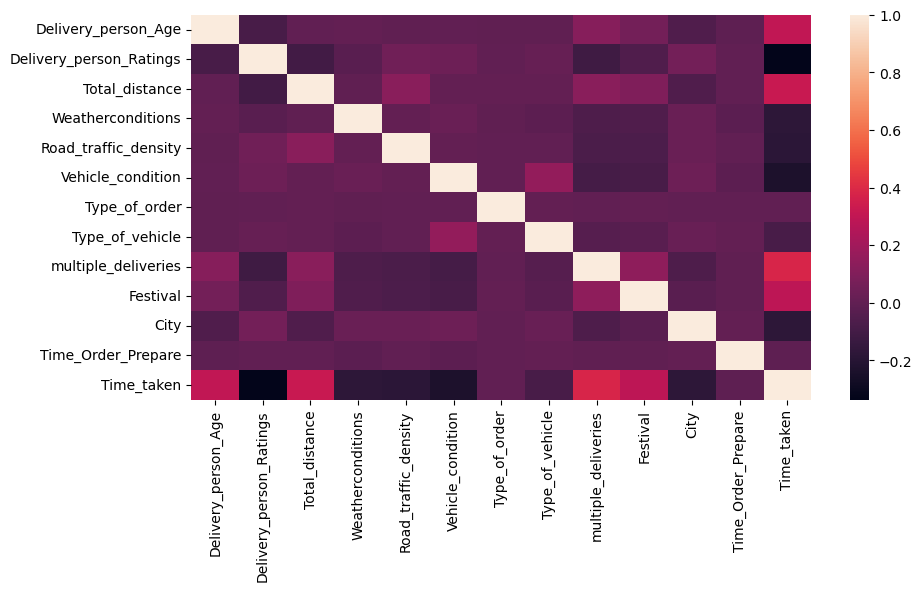

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df.corr(), cmap="rocket", ax=ax)
plt.show()

In [24]:
df = df.drop(["Type_of_order", "Type_of_vehicle", "Time_Order_Prepare"], axis=1)

In [25]:
X_train = df.drop(["Time_taken"], axis=1)
Y_train = df["Time_taken"]

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

In [27]:
models = [ 
    LinearRegression(),
    Lasso(),
    DecisionTreeRegressor(),
    xgb.XGBRegressor(),
    RandomForestRegressor()
]

param_grid = [
    {},
    {'alpha': [0.1, 1.0, 10.0]},
    {'max_depth': [3, 5, 7]},
    {'n_estimators': [20, 25, 30], 'max_depth': [5, 7, 9]},
    {'n_estimators': [100, 200, 300]}
]

for i, model in enumerate(models):
    grid_search = GridSearchCV(model, param_grid[i], cv=5, scoring='r2')
    grid_search.fit(X_train, Y_train)

    print(f"{model.__class__.__name__}:")
    print("Best parameters:", grid_search.best_params_)
    print("Best R2 score:", grid_search.best_score_)
    print("-"*100)

LinearRegression:
Best parameters: {}
Best R2 score: 0.48994804177871815
----------------------------------------------------------------------------------------------------
Lasso:
Best parameters: {'alpha': 0.1}
Best R2 score: 0.4891809119301406
----------------------------------------------------------------------------------------------------
DecisionTreeRegressor:
Best parameters: {'max_depth': 7}
Best R2 score: 0.7348618075262715
----------------------------------------------------------------------------------------------------
XGBRegressor:
Best parameters: {'max_depth': 7, 'n_estimators': 25}
Best R2 score: 0.8300083450241541
----------------------------------------------------------------------------------------------------
RandomForestRegressor:
Best parameters: {'n_estimators': 300}
Best R2 score: 0.8033447279508952
----------------------------------------------------------------------------------------------------


In [28]:
def preprocessing_test_data(df):
    df = df.replace('NaN', float(np.nan), regex=True)
    df[["Word", "Weatherconditions"]] = df["Weatherconditions"].str.split(" ", expand=True)
    
    num_cols = ["Delivery_person_Age", "Delivery_person_Ratings", "Vehicle_condition", "multiple_deliveries"]
    for i in num_cols:
        df[i] = df[i].astype("float64")

    distance = []
    for row in df.iterrows():
        lat1, lon1 = row[1]["Restaurant_latitude"], row[1]["Restaurant_longitude"]
        lat2, lon2 = row[1]["Delivery_location_latitude"], row[1]["Delivery_location_longitude"]
        
        loc1 = (lat1, lon1)
        loc2 = (lat2, lon2)
        result = round(hs.haversine(loc1,loc2,unit=Unit.KILOMETERS), 0)
        distance.append(result)
    df.insert(8, "Total_distance", distance, True)
    
    df = df.drop(
    ["Restaurant_latitude", "Restaurant_longitude", "Delivery_location_latitude", "Delivery_location_longitude",
     "Time_Orderd", "Time_Order_picked", "Order_Date", "ID", "Delivery_person_ID", "Word", "Type_of_order", "Type_of_vehicle"], 
    axis=1)
    
    impute = SimpleImputer(strategy="median")
    df[["Delivery_person_Age", "Delivery_person_Ratings"]] = impute.fit_transform(df[["Delivery_person_Age", "Delivery_person_Ratings"]])

    impute = SimpleImputer(strategy="most_frequent")
    df[["multiple_deliveries", "City", "Festival"]] = impute.fit_transform(df[["multiple_deliveries", "City", "Festival"]])
    
    df["Weatherconditions"].fillna(np.random.choice(df["Weatherconditions"]), inplace=True)
    df["Road_traffic_density"].fillna(np.random.choice(df["Road_traffic_density"]), inplace=True)
    
    cols_list = ["Weatherconditions", "Road_traffic_density", "Festival", "City"]
    for cols in cols_list:
        df[cols] = LabelEncoder().fit_transform(df[cols])
    
    df["multiple_deliveries"] = df["multiple_deliveries"].astype("float64")
    
    return df

In [29]:
test_df = pd.read_csv(r"test.csv")

In [31]:
test_df = preprocessing_test_data(test_df)

In [32]:
test_df

,Delivery_person_Age,Delivery_person_Ratings,Total_distance,Weatherconditions,Road_traffic_density,Vehicle_condition,multiple_deliveries,Festival,City
0,30.0,4.7,6.0,0,2,3.0,1.0,0,0
1,28.0,4.6,17.0,5,1,0.0,1.0,0,0
2,23.0,4.5,13.0,3,1,0.0,1.0,0,0
3,21.0,4.8,13.0,1,3,1.0,1.0,0,0
4,31.0,4.6,17.0,4,3,2.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...
11394,35.0,4.6,16.0,4,1,1.0,1.0,0,0
11395,33.0,4.9,1.0,2,0,1.0,1.0,0,0
11396,30.0,4.7,9.0,0,2,3.0,1.0,0,0
11397,27.0,4.7,20.0,2,3,0.0,0.0,0,0


In [33]:
X_test = scaler.transform(test_df)

In [47]:
model = xgb.XGBRegressor(max_depth=7, n_estimators= 25)
model.fit(X_train, Y_train)
Predictions = model.predict(X_test)

In [48]:
df_results = pd.DataFrame(pd.read_csv(r"test.csv")["ID"])
df_results["Time_taken"] = pd.Series(Predictions)

In [49]:
df_results

,ID,Time_taken
0,0x2318,20.790947
1,0x3474,31.185442
2,0x9420,29.843784
3,0x72ee,30.672846
4,0xa759,22.817762
...,...,...
11394,0x6909,22.775763
11395,0x443b,29.868942
11396,0x1ea5,19.659851
11397,0x22d4,26.831526
